# Your work here!

In [1]:
# good luck :]
# import pyspark

In [2]:
import matplotlib.pylab as plt #Visualization
import numpy as np # linear algebra
import pandas as pd # data pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler # transforming data(normalize/standardize)
from pathlib import Path
import time # wall time
import os

In [3]:
npTrainMatrix =np.load('data/2018-01-01__2019-01-01__NConservatory_npWeekdayAllOrderedSensorsTimeRef.npy')
npTrainMatrix.shape

(20007, 2112)

In [4]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader
import joblib
trainingData=npTrainMatrix
test_data = joblib.load('./test_data/test_dataset_2019.numpy')
test_data.shape

(9898, 2112)

In [5]:
dataLoaderTrain = DataLoader( trainingData.astype('float32'), 
                              batch_size = 18, 
                              shuffle = True )

dataLoaderTest = DataLoader( test_data.astype('float32'), 
                             batch_size = 18, 
                             shuffle = False )

In [6]:
inputDimensionality = trainingData.shape[1]
encoderModel = nn.Sequential(
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.ELU(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.ELU(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.ELU()
)
decoderModel = nn.Sequential(
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.ELU(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.ELU(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

# combine
list_of_layers = list(encoderModel.children())
list_of_layers.extend(list(decoderModel.children()))
model = nn.Sequential (*list_of_layers)

# sanity check
list( nn.Sequential(*list(model.children())[0:6]).parameters() ) == list(encoderModel.parameters())

True

In [7]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

In [8]:
def train_model ( model, dataLoader, targetDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

In [9]:
startTime = time.time()

model, lossHistory = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 10 )

print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 10 -- avg batch loss: 102.48679767549038
epoch 1 of 10 -- avg batch loss: 66.01168463379145
epoch 2 of 10 -- avg batch loss: 58.15719835087657
epoch 3 of 10 -- avg batch loss: 54.16476408392191
epoch 4 of 10 -- avg batch loss: 51.704566083848476
epoch 5 of 10 -- avg batch loss: 49.37479520216584
epoch 6 of 10 -- avg batch loss: 47.166845094412565
epoch 7 of 10 -- avg batch loss: 45.785805366933346
epoch 8 of 10 -- avg batch loss: 44.381768049672246
epoch 9 of 10 -- avg batch loss: 43.69910876825452
elapsed time : 75.36153864860535 


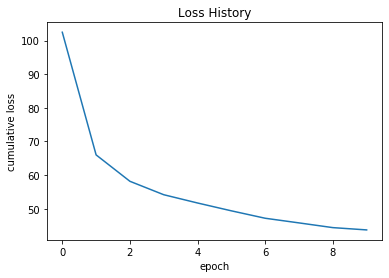

In [10]:
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

In [11]:
def evaluate_model ( model, dataLoader, targetDevice):
    
    predictions, losses = [], []
    
    with torch.no_grad():
        
        model=model.eval()
        
        for seq_true in iter(dataLoader):

            
            reconstruction = model.forward(seq_true.to(targetDevice))
            
            sampleNumpy = seq_true.numpy()
            reconstructionNumpy = reconstruction.data.cpu().numpy()

            error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
            
            losses.append(error)
            predictions.append(reconstructionNumpy.flatten())

            
            
    return predictions,losses
        


In [12]:
predictions,pred_losses=evaluate_model( model, dataLoaderTest, targetDeviceGPU)

In [13]:
# correct = sum(l >= 6250 for l in pred_losses)
# print(f'Correct predictions: {correct}/{len(dataLoaderTest)}')

In [16]:
a=[]
count=0
for days in pred_losses:
    for day in days:
        c=0
        for item in day[0:1536]:
            if item > 0.5:
                c+=1
        a.append(c)

In [17]:
submission=[]
for i,v in enumerate(a):
    submission.append([i+1,v])

In [18]:
di = {}
for i in range(len(a)):
    di[i+1] = a[i]

In [19]:
with open ('submission.txt', 'w') as fp:
    for p in di.items():
        fp.write("%s,%s\n" % p)

In [20]:
import csv
w = csv.writer(open("submission.csv", "w"))
for key, val in di.items():
    w.writerow([key, val])

In [21]:
def parse_submission ( filename ):
    dayIndicators = [] 
    startSampleIndicators = []
    lineCount = 0 
    with open(filename) as submission_text:
        line = submission_text.readline()        
        while line:
            if lineCount > 200: break
                    
            dayIndicators += [line.split(',')[0].strip()]
            startSampleIndicators += [line.split(',')[1].strip()]
            
            print( f'parsing line#{lineCount}: {line}' )
            line = submission_text.readline()
            lineCount += 1
            
    return dayIndicators, startSampleIndicators

In [22]:
parse_submission ( 'submission.txt')

parsing line#0: 1,49

parsing line#1: 2,18

parsing line#2: 3,77

parsing line#3: 4,80

parsing line#4: 5,65

parsing line#5: 6,70

parsing line#6: 7,83

parsing line#7: 8,467

parsing line#8: 9,126

parsing line#9: 10,61

parsing line#10: 11,61

parsing line#11: 12,96

parsing line#12: 13,155

parsing line#13: 14,206

parsing line#14: 15,64

parsing line#15: 16,98

parsing line#16: 17,74

parsing line#17: 18,135

parsing line#18: 19,53

parsing line#19: 20,39

parsing line#20: 21,113

parsing line#21: 22,116

parsing line#22: 23,74

parsing line#23: 24,89

parsing line#24: 25,87

parsing line#25: 26,160

parsing line#26: 27,53

parsing line#27: 28,89

parsing line#28: 29,51

parsing line#29: 30,71

parsing line#30: 31,91

parsing line#31: 32,43

parsing line#32: 33,76

parsing line#33: 34,40

parsing line#34: 35,71

parsing line#35: 36,57

parsing line#36: 37,71

parsing line#37: 38,61

parsing line#38: 39,65

parsing line#39: 40,100

parsing line#40: 41,326

parsing line#41: 42,90

p

(['1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '90',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',
  '97',
  '98',
  '99',
  '100',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '120',
  '121',
  '122',
  '123',
 